In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "LSD"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = True

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
0,Achn003131,MWRLPYIAYVCTWGNKCEMLLLSNGEPCASSLPNYSCLNFGFTILH...,238,1
1,EMT22195,MQSQIVCHGCRSVLLYPRGAPSVCCAVCHAVTNAPPPGMEMAQLIC...,197,1
2,EMT24478,MPVPLAPYPTPPVPFTPPAPNAGAQSQLVCSGCRNLLMYPAGATSV...,146,1
3,AA53G00240,MNIAGSGNGGQSQLVCSGCRNLLMYPVGATSVCCAVCNAVTAVPPP...,120,1
4,AA57G00277,LFRIESIPSPIEVFPGFDLDSGFGSKLSSIFLNPFEFQDKIRNILL...,225,1


In [8]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [9]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [10]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
612,0.010870,0.000000,0.000000,0.0,0.000000,0.016304,0.005435,0.000000,0.000000,0.000000,...,0.0,0.010870,0.005435,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
649,0.009901,0.000000,0.000000,0.0,0.000000,0.000000,0.009901,0.004950,0.000000,0.004950,...,0.0,0.004950,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1323,0.004494,0.000000,0.002247,0.0,0.002247,0.006742,0.006742,0.002247,0.004494,0.002247,...,0.0,0.002247,0.000000,0.0,0.002247,0.002247,0.0,0.0,0.0,0.0
96,0.000000,0.000000,0.000000,0.0,0.000000,0.005208,0.015625,0.000000,0.000000,0.005208,...,0.0,0.010417,0.000000,0.0,0.000000,0.005208,0.0,0.0,0.0,0.0
793,0.000000,0.005714,0.005714,0.0,0.000000,0.000000,0.011429,0.005714,0.000000,0.005714,...,0.0,0.011429,0.000000,0.0,0.005714,0.005714,0.0,0.0,0.0,0.0


In [11]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (1511, 439)
X_test: (378, 439)
y_train: (1511,)
y_test: (378,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [12]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         112,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 155,905 (609.00 KB)

 Trainable params: 155,905 (609.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 8s 475ms/step - accuracy: 0.4844 - loss: 0.6932

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6942 - loss: 0.6810 - val_accuracy: 0.8878 - val_loss: 0.5696


Epoch 2/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8125 - loss: 0.5996

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9078 - loss: 0.4830 - val_accuracy: 0.9868 - val_loss: 0.1363


Epoch 3/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9219 - loss: 0.1879

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9743 - loss: 0.1133 - val_accuracy: 0.9967 - val_loss: 0.0265


Epoch 4/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0349

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9858 - loss: 0.0478 - val_accuracy: 0.9967 - val_loss: 0.0207


Epoch 5/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0266

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9877 - loss: 0.0381 - val_accuracy: 0.9967 - val_loss: 0.0161


Epoch 6/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0594

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9929 - loss: 0.0255 - val_accuracy: 0.9868 - val_loss: 0.0349


Epoch 7/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0148

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9929 - loss: 0.0250 - val_accuracy: 0.9967 - val_loss: 0.0133


Epoch 8/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0378

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9955 - loss: 0.0124 - val_accuracy: 0.9967 - val_loss: 0.0133


Epoch 9/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0218

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0113 - val_accuracy: 0.9967 - val_loss: 0.0142


Epoch 10/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0108

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9962 - loss: 0.0129 - val_accuracy: 0.9967 - val_loss: 0.0086


Epoch 11/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0019

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9969 - loss: 0.0069 - val_accuracy: 0.9967 - val_loss: 0.0081


Epoch 12/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0031

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9984 - loss: 0.0057 - val_accuracy: 0.9967 - val_loss: 0.0077


Epoch 13/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0288

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0084 - val_accuracy: 1.0000 - val_loss: 0.0094


Epoch 14/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0040

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.9967 - val_loss: 0.0122


Epoch 15/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.7041e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0057 - val_accuracy: 0.9967 - val_loss: 0.0099


Epoch 16/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.0424e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9967 - val_loss: 0.0058


Epoch 17/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.3469e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 9.5128e-04 - val_accuracy: 0.9967 - val_loss: 0.0076


Epoch 18/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0064

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9967 - val_loss: 0.0053


Epoch 19/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.8468e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 5.5492e-04 - val_accuracy: 0.9967 - val_loss: 0.0063


Epoch 20/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0017

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9967 - val_loss: 0.0051


Epoch 21/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.6837e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 7.7275e-04 - val_accuracy: 1.0000 - val_loss: 0.0042


Epoch 22/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.0844e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 5.3295e-04 - val_accuracy: 0.9967 - val_loss: 0.0063


Epoch 23/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.5846e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.6968e-04 - val_accuracy: 0.9967 - val_loss: 0.0073



[Train Accuracy: 100.00% - Test Accuracy: 99.74%]


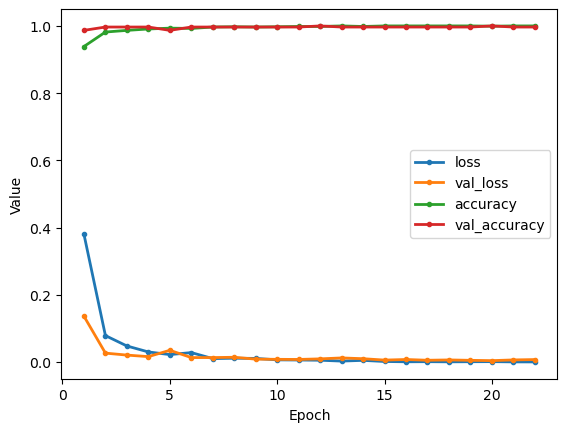

In [13]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [14]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [15]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
612,0.0,0.0,0.0,0.0,0.0,0.005464,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
649,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1323,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
793,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (1511, 8369)
X_test: (378, 8369)
y_train: (1511,)
y_test: (378,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [17]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,142,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,185,985 (8.34 MB)

 Trainable params: 2,185,985 (8.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 8s 480ms/step - accuracy: 0.4844 - loss: 0.6931

 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6020 - loss: 0.6912  

18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7010 - loss: 0.6839

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7153 - loss: 0.6816 - val_accuracy: 0.9736 - val_loss: 0.5622


Epoch 2/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9844 - loss: 0.5574

10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9833 - loss: 0.5165 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9772 - loss: 0.4626

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9769 - loss: 0.4571 - val_accuracy: 0.9736 - val_loss: 0.1028


Epoch 3/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.1021

10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9813 - loss: 0.0920 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9850 - loss: 0.0759

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9852 - loss: 0.0746 - val_accuracy: 0.9967 - val_loss: 0.0163


Epoch 4/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0147

10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0118 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9990 - loss: 0.0119

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9989 - loss: 0.0120 - val_accuracy: 1.0000 - val_loss: 0.0189


Epoch 5/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0160

10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0099 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0075

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0074 - val_accuracy: 1.0000 - val_loss: 0.0016


Epoch 6/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 8.0412e-04

10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0017     

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 8.6750e-04


Epoch 7/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 8.6128e-04

10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.0285e-04 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.2103e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.2174e-04 - val_accuracy: 1.0000 - val_loss: 4.2627e-04


Epoch 8/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 2.9825e-04

10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.5081e-04 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.3826e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.4345e-04 - val_accuracy: 1.0000 - val_loss: 3.6292e-04


Epoch 9/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 4.4866e-04

10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.0574e-04 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.2412e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.2494e-04 - val_accuracy: 1.0000 - val_loss: 2.9604e-04


Epoch 10/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.7186e-04

10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.0675e-04 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.3779e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.3957e-04 - val_accuracy: 1.0000 - val_loss: 2.3414e-04


Epoch 11/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.7087e-04

10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7474e-04 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7374e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.7412e-04 - val_accuracy: 1.0000 - val_loss: 2.5241e-04


Epoch 12/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 9.7067e-05

10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4070e-04 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0549e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.1054e-04 - val_accuracy: 1.0000 - val_loss: 1.8081e-04


Epoch 13/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 2.1868e-04

10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8757e-04 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0278e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.0432e-04 - val_accuracy: 1.0000 - val_loss: 1.6914e-04


Epoch 14/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0013

10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.7883e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.2748e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.2527e-04 - val_accuracy: 1.0000 - val_loss: 1.3857e-04



[Train Accuracy: 100.00% - Test Accuracy: 100.00%]


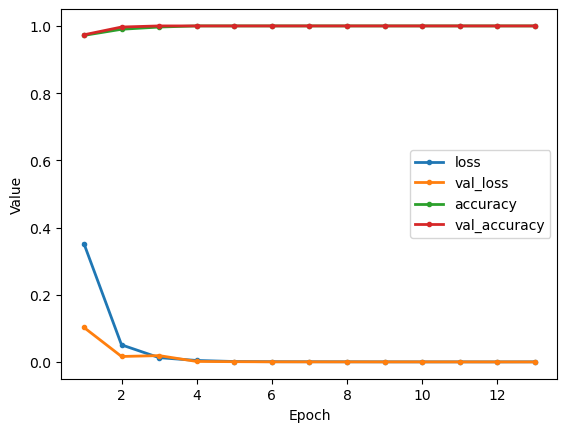

In [18]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [19]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [20]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYL,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYX,YYYY
612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
649,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
793,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      27,860,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,901,441 (106.44 MB)

 Trainable params: 27,901,441 (106.44 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 11s 614ms/step - accuracy: 0.4219 - loss: 0.6932

 2/19 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.4141 - loss: 0.6933  

 3/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.4306 - loss: 0.6933

 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.4538 - loss: 0.6933

 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.4786 - loss: 0.6932

 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.4996 - loss: 0.6931

 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5146 - loss: 0.6930

 8/19 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5228 - loss: 0.6929

 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5295 - loss: 0.6928

10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5339 - loss: 0.6927

11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5373 - loss: 0.6926

12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5401 - loss: 0.6924

13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5435 - loss: 0.6922

14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5482 - loss: 0.6920

15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5533 - loss: 0.6918

16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5584 - loss: 0.6916

17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5638 - loss: 0.6914

18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5694 - loss: 0.6911

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5752 - loss: 0.6908

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.5804 - loss: 0.6906 - val_accuracy: 0.9604 - val_loss: 0.6619


Epoch 2/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.9688 - loss: 0.6591

 2/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9766 - loss: 0.6579

 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9792 - loss: 0.6567

 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9805 - loss: 0.6554

 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9819 - loss: 0.6541

 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9832 - loss: 0.6528

 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9843 - loss: 0.6513

 8/19 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9853 - loss: 0.6497

 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9861 - loss: 0.6481

10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9869 - loss: 0.6464

11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9876 - loss: 0.6445

12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9881 - loss: 0.6425

13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9883 - loss: 0.6403

14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9886 - loss: 0.6379

15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9888 - loss: 0.6355

16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9890 - loss: 0.6329

17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9891 - loss: 0.6303

18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9892 - loss: 0.6276

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9892 - loss: 0.6248

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9891 - loss: 0.6224 - val_accuracy: 0.9604 - val_loss: 0.4234


Epoch 3/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 1.0000 - loss: 0.4090

 2/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.4061

 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9983 - loss: 0.4019

 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9967 - loss: 0.3965

 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9949 - loss: 0.3911

 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9940 - loss: 0.3852

 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9936 - loss: 0.3793

 8/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9932 - loss: 0.3737

 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9930 - loss: 0.3678

10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9927 - loss: 0.3619

11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9926 - loss: 0.3559

12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9926 - loss: 0.3503

13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9926 - loss: 0.3447

14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9926 - loss: 0.3393

15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9925 - loss: 0.3340

16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9925 - loss: 0.3286

17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9924 - loss: 0.3235

18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9923 - loss: 0.3185

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9923 - loss: 0.3136

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9922 - loss: 0.3092 - val_accuracy: 0.9670 - val_loss: 0.0987


Epoch 4/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 0.0406

 2/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0448

 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9983 - loss: 0.0475

 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9977 - loss: 0.0481

 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9976 - loss: 0.0481

 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9975 - loss: 0.0477

 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9976 - loss: 0.0471

 8/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9976 - loss: 0.0464

 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9977 - loss: 0.0459

10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9978 - loss: 0.0454

11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9978 - loss: 0.0449

12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9979 - loss: 0.0443

13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9980 - loss: 0.0436

14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9980 - loss: 0.0430

15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9981 - loss: 0.0423

16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9982 - loss: 0.0417

17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9982 - loss: 0.0411

18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9983 - loss: 0.0405

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9983 - loss: 0.0399

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.9984 - loss: 0.0393 - val_accuracy: 0.9835 - val_loss: 0.0382


Epoch 5/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 0.0088

 2/19 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.0101

 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0104

 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0102

 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0098

 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0095

 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0092

 8/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0089

 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0087

10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0084

11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0082

12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0080

13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0078

14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0077

15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0075

16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0074

17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0073

18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0072

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0071

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 0.0070 - val_accuracy: 0.9802 - val_loss: 0.0382


Epoch 6/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 0.0019

 2/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0022

 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0023

 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0022

 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 0.0022

 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 0.0022

 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 0.0022

 8/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 0.0022

 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 0.0022

10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 0.0022

11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 0.0021

12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0021

13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0021

14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0021

15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0021

16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0021

17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0020

18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0020

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0020

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9835 - val_loss: 0.0353


Epoch 7/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 0.0018

 2/19 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.0015

 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0014

 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0014

 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0013

 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0013

 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0013

 8/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0013

 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0012

10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0012

11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0012

12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0012

13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0012

14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0012

15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0012

16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0012

17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0012

18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0012

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0012

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9802 - val_loss: 0.0400


Epoch 8/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 0.0011

 2/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 9.4336e-04

 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 8.9037e-04

 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 8.6392e-04

 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 8.4172e-04

 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 8.1773e-04

 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 7.9604e-04

 8/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 7.8042e-04

 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 7.7140e-04

10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 7.6167e-04

11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 7.5168e-04

12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 7.5612e-04

13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 7.5950e-04

14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 7.6290e-04

15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 7.6421e-04

16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 7.6481e-04

17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 7.6424e-04

18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 7.6275e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 7.6066e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 7.5877e-04 - val_accuracy: 0.9835 - val_loss: 0.0365


Epoch 9/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 4.7894e-04

 2/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 5.0340e-04

 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 5.4839e-04

 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 5.5904e-04

 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 5.5047e-04

 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 5.5008e-04

 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 5.4586e-04

 8/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 5.3917e-04

 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 5.3113e-04

10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 5.2356e-04

11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 5.1768e-04

12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 5.1199e-04

13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 5.0668e-04

14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 5.0198e-04

15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 4.9878e-04

16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 4.9488e-04

17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 4.9206e-04

18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 4.9005e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 4.9095e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 4.9177e-04 - val_accuracy: 0.9835 - val_loss: 0.0406


Epoch 10/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 3.6342e-04

 2/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 1.0000 - loss: 3.4995e-04

 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 3.6538e-04

 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 3.7805e-04

 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 3.7960e-04

 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 3.7578e-04

 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 3.7051e-04

 8/19 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 3.6615e-04

 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 3.6424e-04

10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 3.6175e-04

11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 3.5945e-04

12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 3.5753e-04

13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 3.5488e-04

14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 3.5313e-04

15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 3.5162e-04

16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 3.5062e-04

17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 3.5074e-04

18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 3.5112e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 3.5138e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 3.5162e-04 - val_accuracy: 0.9835 - val_loss: 0.0398


Epoch 11/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 2.6136e-04

 2/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 1.0000 - loss: 2.8032e-04

 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 1.0000 - loss: 2.8690e-04

 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 2.8246e-04

 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 2.7755e-04

 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 2.7615e-04

 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 2.7972e-04

 8/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 2.8210e-04

 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 2.8275e-04

10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 2.8179e-04

11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 2.7940e-04

12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 2.7708e-04

13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 2.7510e-04

14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 2.7310e-04

15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 2.7087e-04

16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 2.6849e-04

17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 2.6646e-04

18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 2.6453e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 2.6315e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 2.6192e-04 - val_accuracy: 0.9802 - val_loss: 0.0445


Epoch 12/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.4543e-04

 2/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 1.0000 - loss: 1.4017e-04

 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 1.5163e-04

 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 1.7845e-04

 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 1.8920e-04

 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 1.9812e-04

 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 2.0195e-04

 8/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 2.0297e-04

 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 2.0696e-04

10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 2.0860e-04

11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 2.1077e-04

12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 2.1164e-04

13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 2.1335e-04

14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 2.1463e-04

15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 2.1539e-04

16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 2.1610e-04

17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 2.1624e-04

18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 2.1605e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 2.1563e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 2.1525e-04 - val_accuracy: 0.9835 - val_loss: 0.0436


Epoch 13/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 8.7310e-05

 2/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 9.2203e-05

 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 1.1807e-04

 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 1.3320e-04

 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 1.4837e-04

 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 1.5488e-04

 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 1.5768e-04

 8/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 1.5832e-04

 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 1.5818e-04

10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 1.5747e-04

11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 1.5653e-04

12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 1.5555e-04

13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 1.5437e-04

14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 1.5401e-04

15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 1.5366e-04

16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 1.5649e-04

17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 1.5902e-04

18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 1.6106e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 1.6275e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 1.6427e-04 - val_accuracy: 0.9835 - val_loss: 0.0403


Epoch 14/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 1.9217e-04

 2/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 1.7852e-04

 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 1.7417e-04

 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 1.7490e-04

 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 1.7386e-04

 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 1.7254e-04

 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 1.7164e-04

 8/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 1.7352e-04

 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 1.7391e-04

10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 1.7390e-04

11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 1.7450e-04

12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 1.7462e-04

13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 1.7461e-04

14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 1.7444e-04

15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 1.7409e-04

16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 1.7341e-04

17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 1.7275e-04

18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 1.7191e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 1.7108e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 1.7033e-04 - val_accuracy: 0.9835 - val_loss: 0.0371



[Train Accuracy: 100.00% - Test Accuracy: 99.74%]


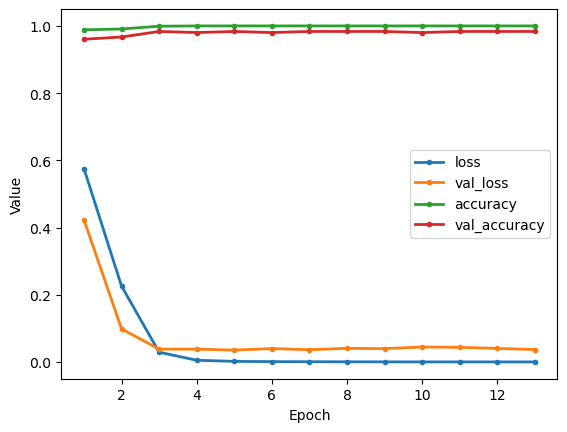

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

 8/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

 8/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [25]:
report.save()

Report saved as Output/Reports/LSD/report_KOHI5VRC.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [26]:
"""k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()"""

"k = 5\nX, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nX_test.head()"

In [27]:
"""NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]"""

'NUM_CLASS  = 1\nSEQ_LENGTH = X_train.shape[1]'

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [28]:
"""name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'name="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n# Evaluate and sc

In [29]:
"""VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"""

"VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"

In [30]:
"""VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('end')"""

'VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) \nreport.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])\nreport.save(\'end\')'

In [31]:
# END

In [32]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################